In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import pickle
from datetime import timedelta
from scipy.stats import norm

In [2]:
def japan_map():
    shapefile_path = "ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
    japan_admin1 = gpd.read_file(shapefile_path)
    japan = japan_admin1[japan_admin1["admin"] == "Japan"]
    return japan

japan = japan_map()

# 1. Clustering

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

def plot_mainshock_context_1(i, flag=""):
    with open(f"1_clustering/before_list1_{flag}.pkl", "rb") as f:
        before_event_list1 = pickle.load(f)
    mainshock_df = pd.read_csv(f"mainshock_df_{flag}.csv")
    mainshock = mainshock_df.iloc[i]
    before_df = before_event_list1[i]

    main_time = pd.to_datetime(mainshock["datetime"])
    main_lat, main_lon = mainshock["latitude"], mainshock["longitude"]
    main_mag = mainshock["magnitude"]
    main_depth = mainshock['depth']
    mx, my, mz = mainshock["x"], mainshock["y"], mainshock["z"]
    foreshock_flag = mainshock['TF_clustering']

    if not before_df.empty:
        before_df = before_df.copy()
        before_df["time_diff_days"] = (pd.to_datetime(before_df["datetime"]) - main_time).dt.total_seconds() / 86400
        dx = before_df["x"].values - mx
        dy = before_df["y"].values - my
        dz = before_df["z"].values - mz
        dists = np.sqrt(dx*dx + dy*dy + dz*dz)
        before_df['main_distance'] = dists
    else:
        before_df = pd.DataFrame(columns=["time_diff_days", "magnitude", "latitude", "longitude", "main_distance"])

    norm = mcolors.Normalize(vmin=0, vmax=1000)
    cmap1 = mcolors.LinearSegmentedColormap.from_list('blue_to_white', ["#0000FF", "#ADD8E6"])

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # graph1 : time-magnitude
    axs[0].scatter(before_df['time_diff_days'], before_df['magnitude'], 
                   label="foreshocks", alpha=0.7, c=before_df["main_distance"], cmap=cmap1, norm=norm)
    axs[0].scatter(0, main_mag, color="red", label="Mainshock", marker="*", s=120)
    axs[0].set_xlabel("Days before mainshock")
    axs[0].set_ylabel("Magnitude")
    axs[0].set_title("Time vs Magnitude")
    if not before_df.empty:
        x_min = before_df["time_diff_days"].min() * 1.2
    else:
        x_min = -100
    axs[0].set_xlim(x_min, -x_min*0.01)
    axs[0].set_ylim(-1.1, main_mag+0.3)
    axs[0].grid(True)

    # graph2 : near mainshock map
    japan.plot(ax=axs[1], color="oldlace", edgecolor="black")

    sc1 = axs[1].scatter(before_df['longitude'], before_df['latitude'], 
                   alpha=0.7, c=before_df["main_distance"], cmap=cmap1, norm=norm, s=20)
    axs[1].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title("Spatial Distribution")
    axs[1].grid(True)

    margin = 0.11
    axs[1].set_xlim(main_lon - margin, main_lon + margin)
    axs[1].set_ylim(main_lat - margin, main_lat + margin)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

    # graph3 : wide map
    japan.plot(ax=axs[2], color="oldlace", edgecolor="black")
    axs[2].scatter(before_df['longitude'], before_df['latitude'], 
                    alpha=0.7, c=before_df["main_distance"], cmap=cmap1, norm=norm, s=20)
    axs[2].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[2].set_xlabel("Longitude")
    axs[2].set_ylabel("Latitude")
    axs[2].set_xlim(127, 147)
    axs[2].set_ylim(30, 47)
    axs[2].set_title("Mainshock Location")
    axs[2].grid(True)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)
    fig.colorbar(sc1, ax=axs[2], label=f"Distance from Mainshock (km)")

    plt.suptitle(
        f"Mainshock #{i} - M={main_mag}, Date={main_time.strftime('%Y-%m-%d')}, Depth={main_depth}km\n"
        f"Foreshock : {foreshock_flag}",
        fontsize=14
    )
    fig.legend()
    plt.tight_layout()
    plt.show()

M>=6.0

old : 46, 92, 117, 120, 125, 159, 166, 184, 197, 218, 248, 250, 269

new : 16, 24, 45, 98

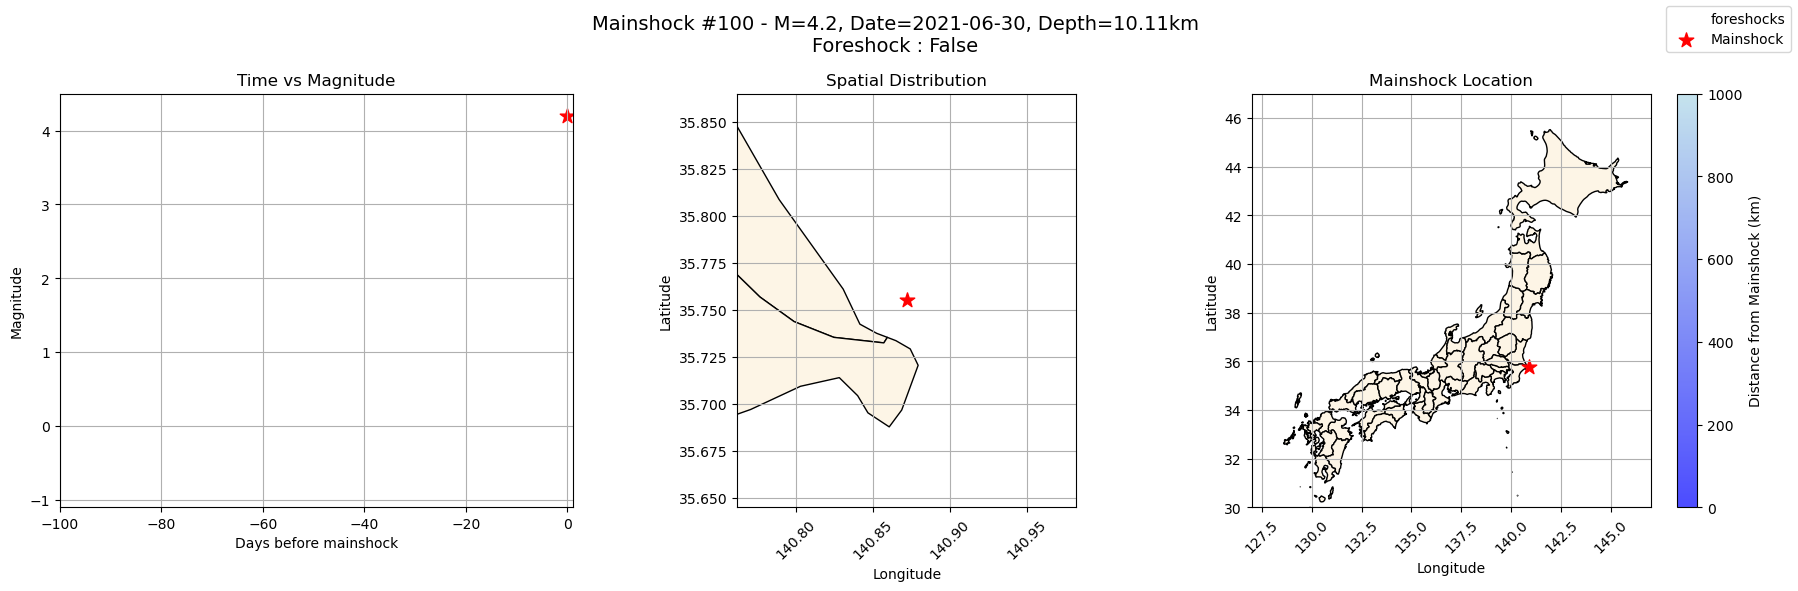

In [143]:
i = 100
flag = "new"
plot_mainshock_context_1(i, flag=flag)

## 2. Space-time window

In [4]:
def plot_mainshock_context_2(i, flag="", T=20):
    with open(f"4_etas/nearby_list4_{flag}.pkl", "rb") as f:
        nearby_event_dfs = pickle.load(f)
    mainshock_df = pd.read_csv(f"mainshock_df_{flag}.csv")
    mainshock = mainshock_df.iloc[i]
    df_nearby = nearby_event_dfs[i]

    main_time = pd.to_datetime(mainshock["datetime"])
    main_lat, main_lon = mainshock["latitude"], mainshock["longitude"]
    main_mag = mainshock["magnitude"]
    main_depth = mainshock['depth']

    if not df_nearby.empty:
        df_nearby = df_nearby.copy()
        df_nearby["time_diff_days"] = (pd.to_datetime(df_nearby["datetime"]) - main_time).dt.total_seconds() / 86400
    else:
        df_nearby = pd.DataFrame(columns=["time_diff_days", "magnitude", "latitude", "longitude"])

    foreshock_flag = mainshock['TF_stw']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # graph1 : time vs magnitude
    recent_mask = (df_nearby["time_diff_days"] >= -T) & (df_nearby["time_diff_days"] <= 0)
    old_mask = (df_nearby["time_diff_days"] < -T) & (df_nearby["time_diff_days"] >= -T-360)

    axs[0].scatter(df_nearby.loc[old_mask, "time_diff_days"], df_nearby.loc[old_mask, "magnitude"], 
                   label=f"Events older than {T} days", alpha=0.7, color="gray")
    axs[0].scatter(df_nearby.loc[recent_mask, "time_diff_days"], df_nearby.loc[recent_mask, "magnitude"], 
                   label=f"Events within {T} days", alpha=0.7, color="blue")
    axs[0].scatter(0, main_mag, color="red", label="Mainshock", marker="*", s=120)
    axs[0].vlines(-T, -1.1, main_mag+0.3, linestyle='--', color='red')
    axs[0].set_xlabel("Days before mainshock")
    axs[0].set_ylabel("Magnitude")
    axs[0].set_title("Time vs Magnitude")
    axs[0].set_xlim(-388, 5)
    axs[0].set_ylim(-1.1, main_mag+0.3)
    axs[0].grid(True)

    # graph2 : nearby map
    japan.plot(ax=axs[1], color="oldlace", edgecolor="black")

    axs[1].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="gray", s=20)
    axs[1].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[1].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title("Spatial Distribution")
    axs[1].grid(True)

    margin = 0.11
    axs[1].set_xlim(main_lon - margin, main_lon + margin)
    axs[1].set_ylim(main_lat - margin, main_lat + margin)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

    # graph3 : wide map
    margin = 1.0
    japan.plot(ax=axs[2], color="oldlace", edgecolor="black")
    axs[2].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="gray", s=20)
    axs[2].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[2].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[2].set_xlabel("Longitude")
    axs[2].set_ylabel("Latitude")
    axs[2].set_title("Location")
    axs[2].set_xlim(main_lon - margin, main_lon + margin)
    axs[2].set_ylim(main_lat - margin, main_lat + margin)
    axs[2].grid(True)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)

    plt.suptitle(
        f"Mainshock #{i} - M={main_mag}, Date={main_time.strftime('%Y-%m-%d')}, Depth={main_depth}km\n"
        f"Foreshock: {foreshock_flag}",
        fontsize=14
    )
    fig.legend()
    plt.tight_layout()
    plt.show()

M>=6.0

old : 46, 92, 117, 120, 125, 159, 166, 184, 197, 218, 248, 250, 269

new : 16, 24, 45, 98

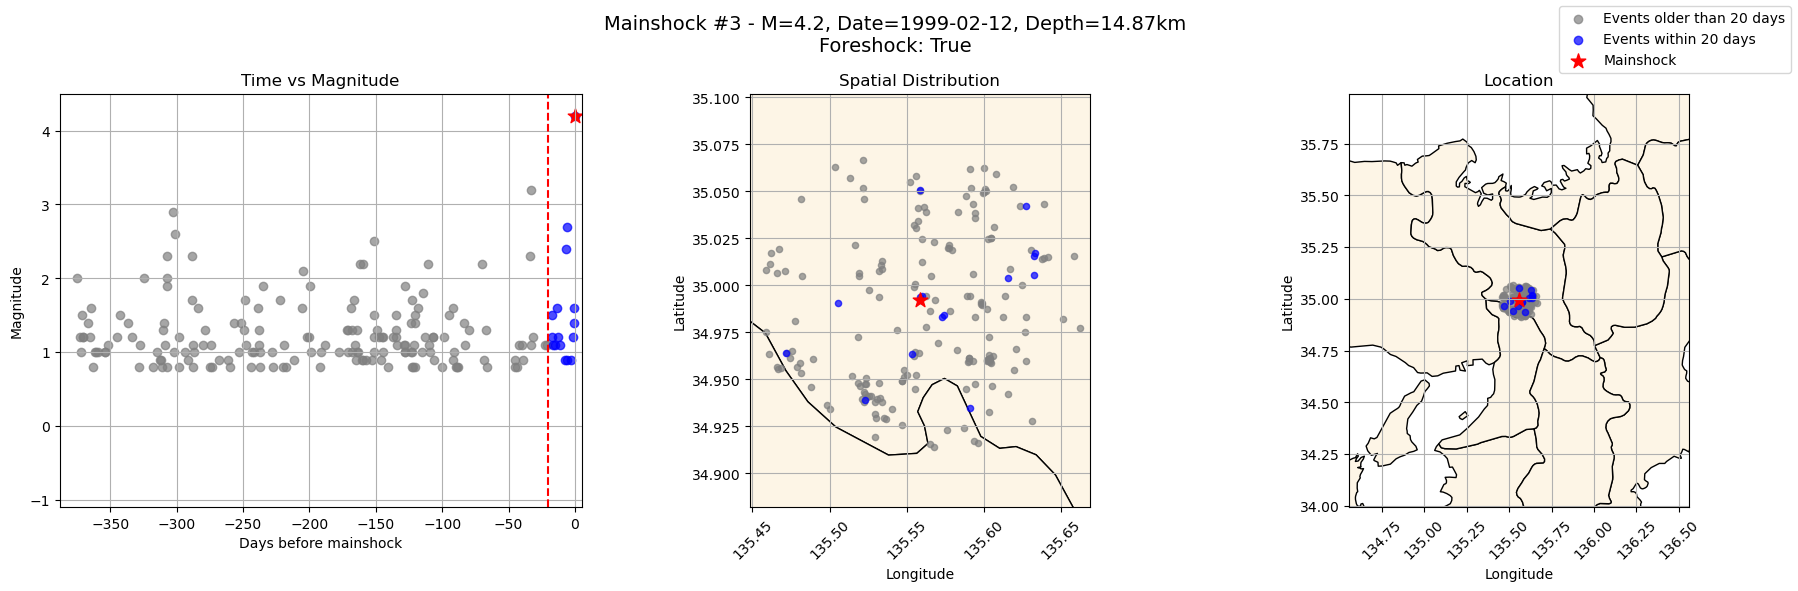

In [43]:
i = 3
flag="old"
plot_mainshock_context_2(i, flag=flag)

## 3. IET

In [194]:
from scipy.stats import gamma as gm

def plot_interevent_hist_with_fit(mainshock_df, df_nearby_list, index, step=1):

    mainshock = mainshock_df.iloc[index]
    main_time = pd.to_datetime(mainshock["datetime"])
    df_nearby = df_nearby_list[index]

    mask = (df_nearby["datetime"] >= main_time - timedelta(days=388)) & \
           (df_nearby["datetime"] <= main_time - timedelta(days=28))
    df_window = df_nearby[mask].sort_values("datetime").copy()

    times = df_window["datetime"].values

    if len(times) == 0:
        inter_event_times = np.array([1e3])
    elif len(times) == 1:
        inter_event_times = np.array([360.0])
    else:
        inter_event_times = np.diff(times).astype("timedelta64[s]").astype(float) / (3600 * 24)
        T_days = 360
        iet_n1 = ((times[0] + np.timedelta64(T_days, 'D')) - times[-1]).astype("timedelta64[s]").astype(float) / (3600 * 24)
        inter_event_times = np.append(inter_event_times, iet_n1)
        inter_event_times = inter_event_times[(inter_event_times > 0) & ~np.isnan(inter_event_times)]

    mu = mainshock["background_mu"]
    gamma = mainshock["background_gamma"]

    plt.figure(figsize=(8, 5))
    bins = np.arange(0, np.max(inter_event_times) + 1, step)

    plt.hist(inter_event_times, bins=bins, density=True, alpha=0.6, color='black', label='Inter-event time histogram')

    x = np.linspace(0.01, np.max(inter_event_times), 500)
    pdf = gm.pdf(x, a=gamma, scale=1/mu) / step
    plt.plot(x, pdf, 'r-', label=f'Gamma fit (γ={gamma:.2f}, μ={mu:.4f})', alpha=0.7, linewidth=3)

    plt.xlabel("Inter-event time [days]")
    plt.ylabel("Density")
    plt.title(f"Mainshock #{index}: Inter-event time and Gamma Fit")
    plt.ylim(0,1.0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def simulate_and_plot_gamma_fit(idx, mainshock_df, T=20, n_trials=50000, seed=42):
    np.random.seed(seed)

    row = mainshock_df.iloc[idx]
    mu = row["background_mu"]
    gamma_shape = row["background_gamma"]
    scale = 1 / mu
    max_len = max(200, int(20 * mu * 1.5 / gamma_shape))

    # シミュレーション
    samples = gm.rvs(a=gamma_shape, scale=scale, size=(n_trials, max_len))
    cumsum = np.cumsum(samples, axis=1)
    N = (cumsum < T).sum(axis=1)

    mu2 = row["iet_mu"]
    gamma2 = row["iet_gamma"]

    # なめらかなx軸（連続）
    x_vals = np.linspace(0, N.max() + 5, 500)

    # パーセンタイル（mainshock_dfから）
    N_99 = gm.ppf(0.99, a=gamma2, scale=1 / mu2)

    # 可視化
    plt.figure(figsize=(10, 6))
    bins = np.arange(N.min(), N.max() + 2) - 0.5
    plt.hist(N, bins=bins, density=True, alpha=0.6, label="Simulated N histogram",
             color="skyblue")

    if np.isnan(mu2):
        print('gamma fitting failed')
    else:
        plt.plot(x_vals, gm.pdf(x_vals, a=gamma2, scale=1/mu2),
                 'r-', lw=2, label="Gamma fit")

    plt.axvline(N_99, color="purple", linestyle="--", label=f"N99 ≈ {N_99:.2f}")

    plt.title(f"Gamma Fit for Mainshock #{idx} (T={T} days, Trials={n_trials}, mu={mu2}, gamma={gamma2})")
    plt.xlabel("Number of Events within T Days")
    plt.ylabel("Density")
    plt.xticks(np.arange(0, N.max() + 5, 1))
    #plt.ylim(0,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mainshock_context_3(i, mainshock_df, nearby_event_dfs, T=20):
    mainshock = mainshock_df.iloc[i]
    df_nearby = nearby_event_dfs[i]

    main_time = pd.to_datetime(mainshock["datetime"])
    main_lat, main_lon = mainshock["latitude"], mainshock["longitude"]
    main_mag = mainshock["magnitude"]
    main_depth = mainshock['depth']

    if not df_nearby.empty:
        df_nearby = df_nearby.copy()
        df_nearby["time_diff_days"] = (pd.to_datetime(df_nearby["datetime"]) - main_time).dt.total_seconds() / 86400
    else:
        df_nearby = pd.DataFrame(columns=["time_diff_days", "magnitude", "latitude", "longitude"])

    foreshock_N99 = mainshock['TF_iet']
    p_value = mainshock['iet_rate']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # graph1 : time vs magnitude
    recent_mask = (df_nearby["time_diff_days"] >= -T) & (df_nearby["time_diff_days"] <= 0)
    old_mask = (df_nearby["time_diff_days"] < -T) & (df_nearby["time_diff_days"] >= -T-360)

    axs[0].scatter(df_nearby.loc[old_mask, "time_diff_days"], df_nearby.loc[old_mask, "magnitude"], 
                   label=f"Events older than {T} days", alpha=0.7, color="black")
    axs[0].scatter(df_nearby.loc[recent_mask, "time_diff_days"], df_nearby.loc[recent_mask, "magnitude"], 
                   label=f"Events within {T} days", alpha=0.7, color="blue")
    axs[0].scatter(0, main_mag, color="red", label="Mainshock", marker="*", s=120)
    axs[0].vlines(-T, -1.1, main_mag+0.3, linestyle='--', color='red')
    axs[0].set_xlabel("Days before mainshock")
    axs[0].set_ylabel("Magnitude")
    axs[0].set_title("Time vs Magnitude")
    axs[0].set_xlim(-T-360, 5)
    axs[0].set_ylim(-1.1, main_mag+0.3)
    axs[0].grid(True)

    # graph2 : nearby map
    japan.plot(ax=axs[1], color="oldlace", edgecolor="black")

    axs[1].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="black", s=20)
    axs[1].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[1].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title("Spatial Distribution")
    axs[1].grid(True)

    margin = 0.11
    axs[1].set_xlim(main_lon - margin, main_lon + margin)
    axs[1].set_ylim(main_lat - margin, main_lat + margin)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

    # graph3 : wide map
    margin = 1.0
    japan.plot(ax=axs[2], color="oldlace", edgecolor="black")
    axs[2].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="black", s=20)
    axs[2].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[2].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[2].set_xlabel("Longitude")
    axs[2].set_ylabel("Latitude")
    axs[2].set_title("Location")
    axs[2].set_xlim(main_lon - margin, main_lon + margin)
    axs[2].set_ylim(main_lat - margin, main_lat + margin)
    axs[2].grid(True)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)

    plt.suptitle(
        f"Mainshock #{i} - M={main_mag}, Date={main_time.strftime('%Y-%m-%d')}, Depth={main_depth}km\n"
        f"Foreshock (99%): {foreshock_N99}, p-value : {p_value}",
        fontsize=14
    )
    fig.legend()
    plt.tight_layout()
    plt.show()

def plot_all_3(i, flag=""):
    with open(f"4_etas/nearby_list4_{flag}.pkl", "rb") as f:
        nearby_event_dfs = pickle.load(f)
    mainshock_df = pd.read_csv(f"mainshock_df_{flag}.csv")
    plot_mainshock_context_3(i, mainshock_df, nearby_event_dfs)
    plot_interevent_hist_with_fit(mainshock_df, nearby_event_dfs, i)
    simulate_and_plot_gamma_fit(i, mainshock_df)

M>=6.0

old : 46, 92, 117, 120, 125, 159, 166, 184, 197, 218, 248, 250, 269

new : 16, 24, 45, 98

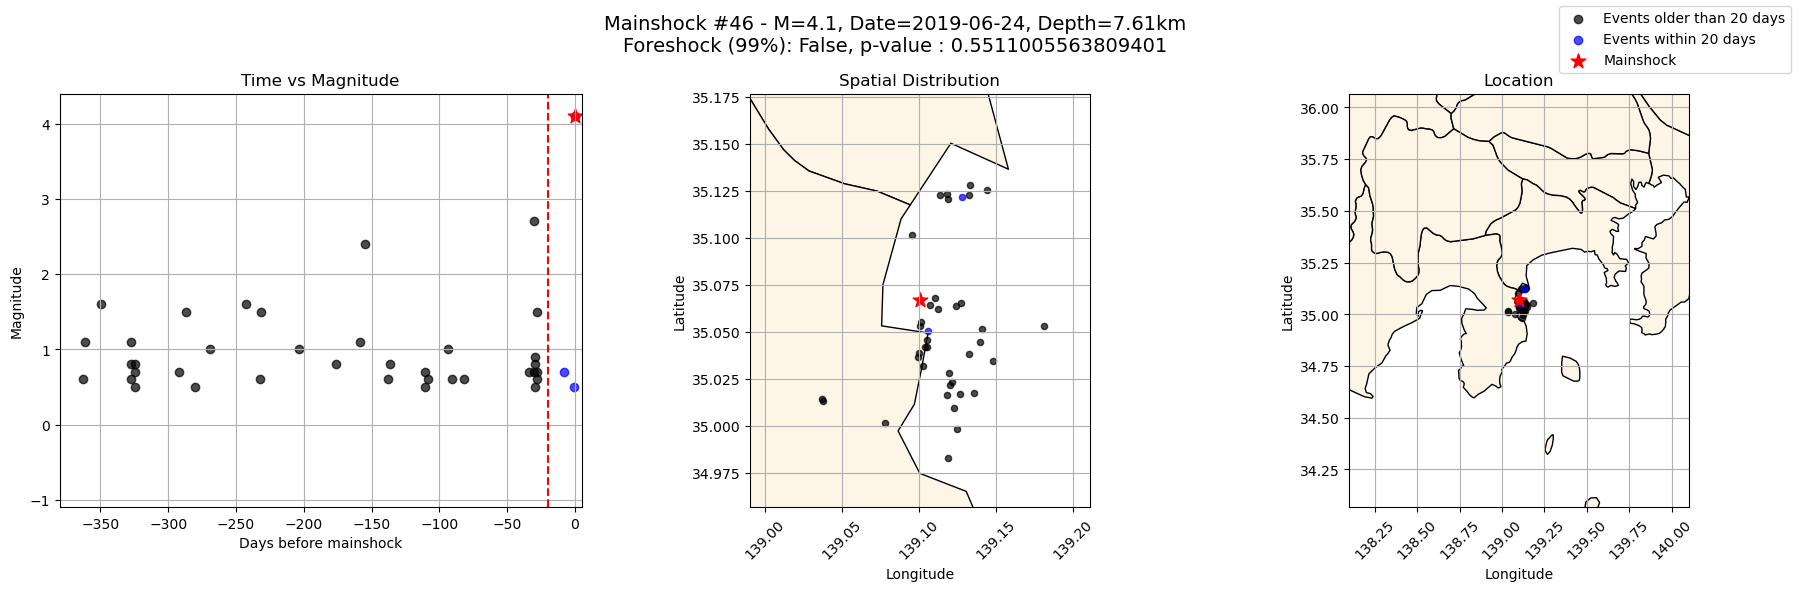

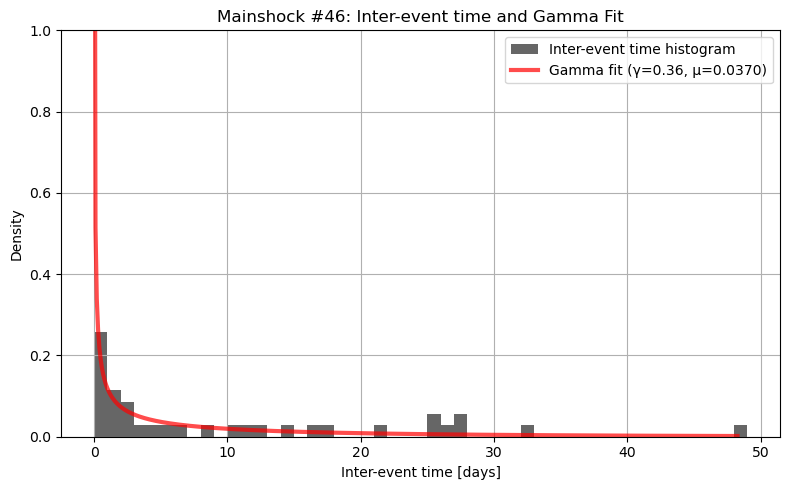

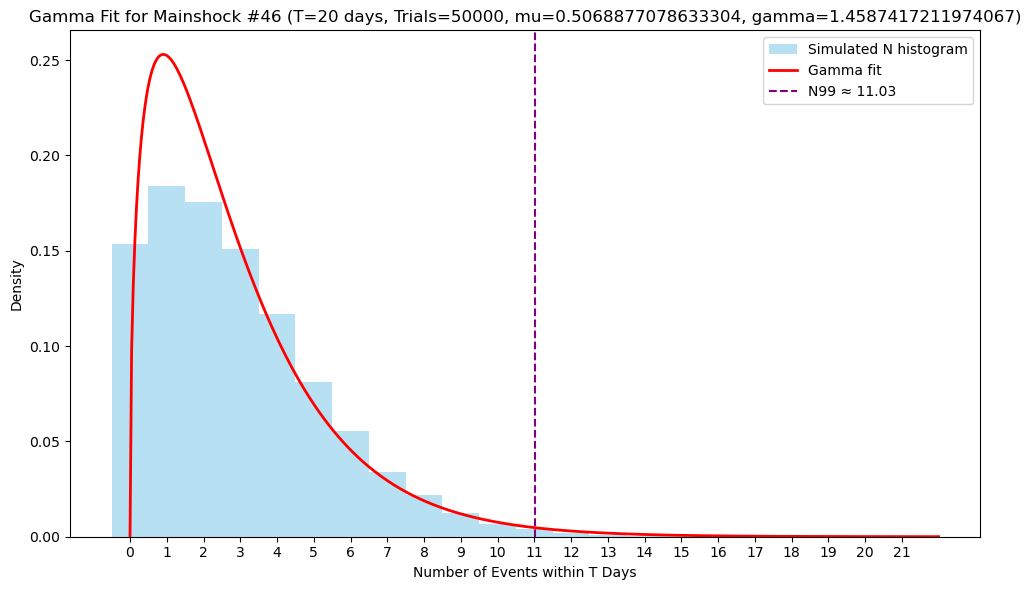

In [240]:
i = 46
flag = "new"
plot_all_3(i, flag=flag)

## 4. ETAS

In [141]:
def plot_mainshock_context_4(i, flag="", T=20):
    with open(f"4_etas/nearby_list4_{flag}.pkl", "rb") as f:
        nearby_event_dfs = pickle.load(f)
    mainshock_df = pd.read_csv(f"mainshock_df_{flag}.csv")
    mainshock = mainshock_df.iloc[i]
    df_nearby = nearby_event_dfs[i]

    main_time = pd.to_datetime(mainshock["datetime"])
    main_lat, main_lon = mainshock["latitude"], mainshock["longitude"]
    main_mag = mainshock["magnitude"]
    main_depth = mainshock['depth']

    if not df_nearby.empty:
        df_nearby = df_nearby.copy()
        df_nearby["time_diff_days"] = (pd.to_datetime(df_nearby["datetime"]) - main_time).dt.total_seconds() / 86400
    else:
        df_nearby = pd.DataFrame(columns=["time_diff_days", "magnitude", "latitude", "longitude"])

    foreshock_N99 = mainshock['TF_etas']
    p_value = mainshock['etas_rate']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # graph1 : time vs magnitude
    recent_mask = (df_nearby["time_diff_days"] >= -T) & (df_nearby["time_diff_days"] <= 0)
    old_mask = (df_nearby["time_diff_days"] < -T) & (df_nearby["time_diff_days"] >= -T-360)

    axs[0].scatter(df_nearby.loc[old_mask, "time_diff_days"], df_nearby.loc[old_mask, "magnitude"], 
                   label=f"Events older than {T} days", alpha=0.7, color="black")
    axs[0].scatter(df_nearby.loc[recent_mask, "time_diff_days"], df_nearby.loc[recent_mask, "magnitude"], 
                   label=f"Events within {T} days", alpha=0.7, color="blue")
    axs[0].scatter(0, main_mag, color="red", label="Mainshock", marker="*", s=120)
    axs[0].vlines(-T, -1.1, main_mag+0.3, linestyle='--', color='red')
    axs[0].set_xlabel("Days before mainshock")
    axs[0].set_ylabel("Magnitude")
    axs[0].set_title("Time vs Magnitude")
    axs[0].set_xlim(-T-360, 5)
    axs[0].set_ylim(0, main_mag+0.3)
    axs[0].grid(True)

    # graph2 : nearby map
    japan.plot(ax=axs[1], color="oldlace", edgecolor="black")

    axs[1].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="black", s=20)
    axs[1].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[1].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title("Spatial Distribution")
    axs[1].grid(True)

    margin = 0.11
    axs[1].set_xlim(main_lon - margin, main_lon + margin)
    axs[1].set_ylim(main_lat - margin, main_lat + margin)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

    # graph3 : wide map
    margin = 1.0
    japan.plot(ax=axs[2], color="oldlace", edgecolor="black")
    axs[2].scatter(df_nearby.loc[old_mask, "longitude"], df_nearby.loc[old_mask, "latitude"], 
                   alpha=0.7, color="black", s=20)
    axs[2].scatter(df_nearby.loc[recent_mask, "longitude"], df_nearby.loc[recent_mask, "latitude"], 
                   alpha=0.7, color="blue", s=20)
    axs[2].scatter(main_lon, main_lat, color="red", marker="*", s=120)
    axs[2].set_xlabel("Longitude")
    axs[2].set_ylabel("Latitude")
    axs[2].set_title("Location")
    axs[2].set_xlim(main_lon - margin, main_lon + margin)
    axs[2].set_ylim(main_lat - margin, main_lat + margin)
    axs[2].grid(True)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)

    plt.suptitle(
        f"Mainshock #{i} - M={main_mag}, Date={main_time.strftime('%Y-%m-%d')}, Depth={main_depth}km\n"
        f"Foreshock (99%): {foreshock_N99}, p-value : {p_value}",
        fontsize=14
    )
    fig.legend()
    plt.tight_layout()
    plt.show()


def plot_etas(idx, flag="", dt_hours=6):

    with open(f"4_etas/nearby_list4_{flag}.pkl", "rb") as f:
        nearby_event_dfs = pickle.load(f)
    mainshock_df = pd.read_csv(f"mainshock_df_{flag}.csv", parse_dates=["datetime"])
    mainshock_row = mainshock_df.iloc[idx]
    df_nearby = nearby_event_dfs[idx]

    if flag == "old":
        Mc = 0.8
        t_start = pd.to_datetime('1998-01-01')
        t_end = pd.to_datetime('2016-03-31')
    elif flag == "new":
        Mc = 0.5
        t_start = pd.to_datetime('2016-04-01')
        t_end = pd.to_datetime('2023-12-31')

    mu    = mainshock_row["etas_mu"]
    K     = mainshock_row["etas_K"]
    c     = mainshock_row["etas_c"]
    alpha = mainshock_row["etas_alpha"]
    p     = mainshock_row["etas_p"]

    if np.isnan(mu):
        print("ETAS parameters missing")
        return

    df = df_nearby.sort_values("datetime").copy()
    times = df["datetime"].values
    mags  = df["magnitude"].values

    t_main = mainshock_row["datetime"].value
    M_main = mainshock_row["magnitude"]

    # transformed time vs cumulative number
    tau_vals = []

    for i in range(len(df)):

        ti = times[i]
        tau = mu * (ti - t_start) / np.timedelta64(1, 'D')

        for j in range(i+1):
            tj = times[j]
            dt = (ti - tj) / np.timedelta64(1, 'D')
            A  = K * np.exp(alpha*(mags[j]-Mc))

            if p != 1:
                tau += A/(1-p)*((dt+c)**(1-p) - (c)**(1-p))
            else:
                tau += A*np.log((dt+c)/(c))

        tau_vals.append(tau)

    N = np.arange(1, len(tau_vals)+1)

    # lambda time series
    t_grid = pd.date_range(t_start, t_end,
                           freq=f"{dt_hours}H")

    lam_series = []

    for t in t_grid:
        lam = mu

        for ti, Mi in zip(times, mags):
            if ti >= t:
                break
            dt = (t - ti) / np.timedelta64(1, 'D')
            lam += K*np.exp(alpha*(Mi-Mc))*(dt+c)**(-p)

        lam_series.append(lam)

    lam_series = np.array(lam_series)

    # plot
    fig = plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1,2,1)
    ax1.plot(tau_vals, N)
    ax1.plot([0, max(tau_vals)], [0, max(tau_vals)], linestyle="--")
    ax1.set_xlabel("Transformed time τ")
    ax1.set_ylabel("Cumulative number N")
    ax1.set_title("Time transformation")
    ax1.set_aspect('equal', adjustable='box')

    ax2 = plt.subplot(1,2,2)
    ax2.scatter(df["datetime"], mags, s=5, label="Events", color="k")
    ax2.scatter(t_main, M_main, s=20, label="Mainshock", color="r", marker="*")
    ax2.set_ylabel("Magnitude")
    ax2.set_xlim(t_start, t_end)
    ax2.set_xlabel("Year")

    ax3 = ax2.twinx()
    ax3.plot(t_grid, lam_series, label="λ(t)", color='lightgreen', alpha=0.6)
    ax3.set_ylabel("λ(t)")
    ax3.set_yscale("log")

    ax2.set_title("Time-Magnitude and ETAS intensity")

    plt.tight_layout()
    plt.show()


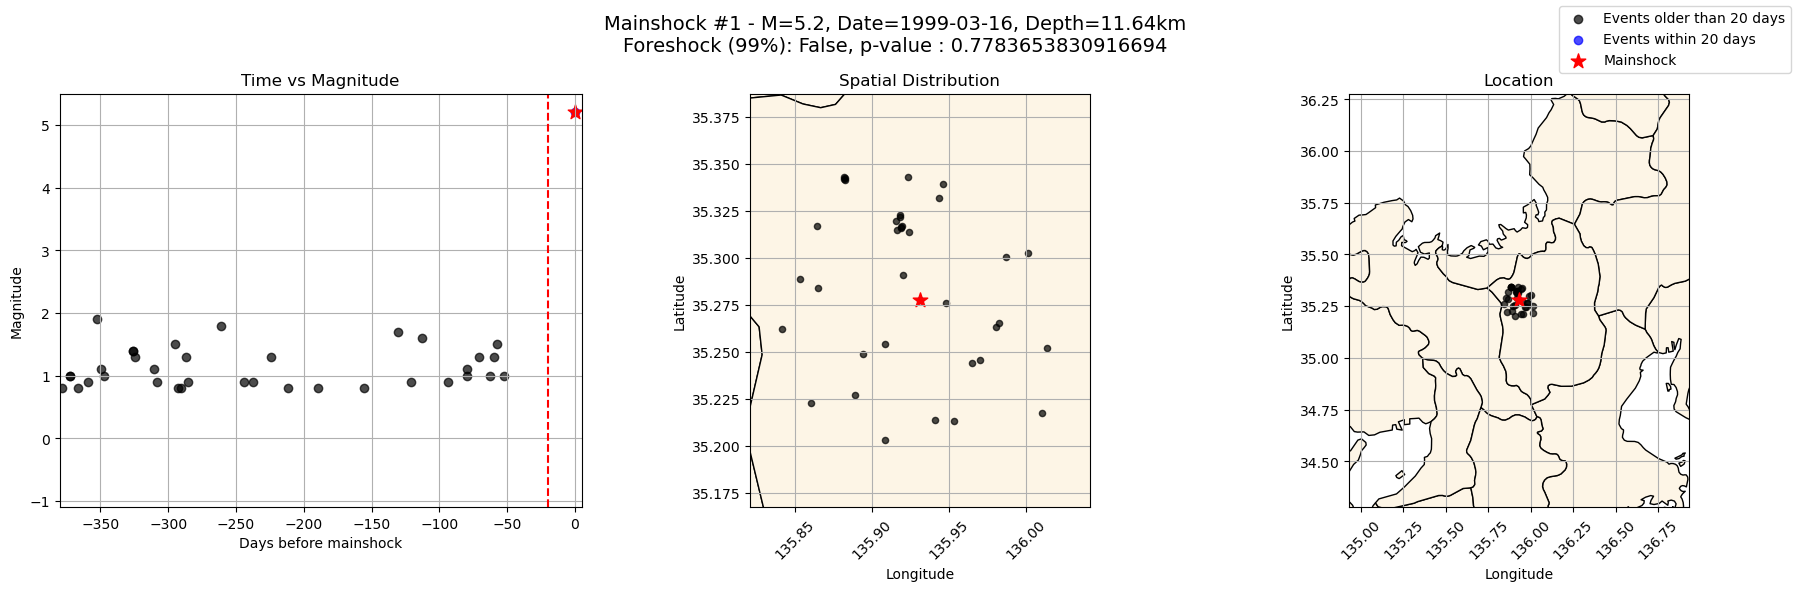

/var/folders/mz/tt41ylld0bqcsz6xxvg777w00000gn/T/ipykernel_10110/2594547618.py:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_grid = pd.date_range(t_start, t_end,


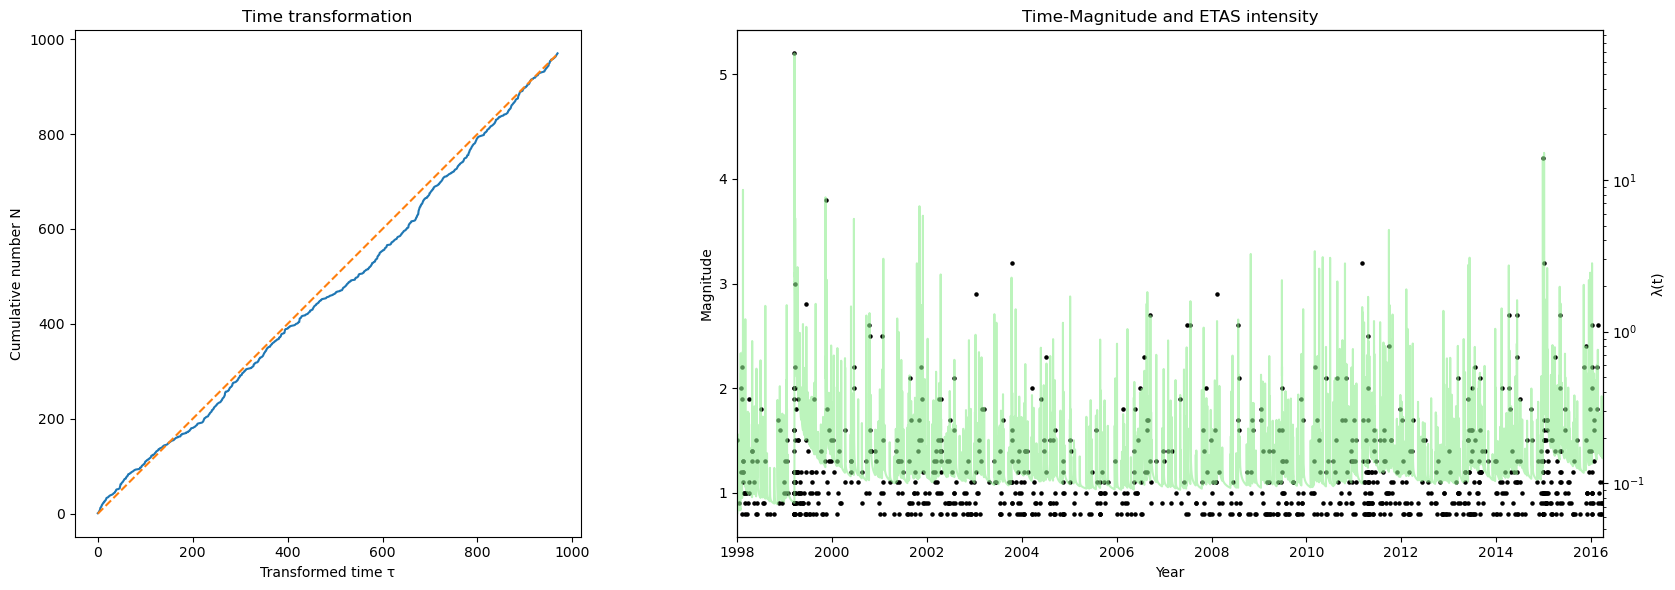

In [143]:
i = 1
flag = "old"
plot_mainshock_context_4(i, flag=flag)
plot_etas(i, flag=flag)